# Feature Category Count Analysis

This notebook calculates and displays statistics for speakers, words, turns, average turn length, and type-token ratio across gender (Female/Male) and age (Old/Young) categories, matching the provided table:

| Feature | Category | Count |
|---------|----------|-------|
| Speakers | Female | 365 |
| | Male | 305 |
| | Old | 56 |
| | Young | 49 |
| Words | Female | 6,671,774 |
| | Male | 4,080,524 |
| | Old | 737,398 |
| | Young | 792,039 |
| Turns | Female | 742,973 |
| | Male | 478,851 |
| | Old | 96,994 |
| | Young | 102,433 |
| Average turn length | Female | 9.42 |
| (in words) | Male | 8.950 |
| | Old | 8.05 |
| | Young | 8.18 |
| Type-token ratio | Female | 0.0073 |
| | Male | 0.011 |
| | Old | 0.0231 |
| | Young | 0.0235 |

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lxml.etree as ET
from collections import Counter, defaultdict

# Set the path to the dataset
path = 'Dataset'  # Change if needed
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_untagged = os.path.join(path, 'spoken', 'untagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Verify directories exist
print(f"Corpus directory exists: {os.path.exists(dir_corpus)}")
print(f"Untagged directory exists: {os.path.exists(dir_untagged)}")
print(f"Metadata directory exists: {os.path.exists(dir_meta)}")

Corpus directory exists: True
Untagged directory exists: True
Metadata directory exists: True


In [2]:
# Load speaker metadata
fields_s = pd.read_csv(
    os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
    sep='\t', skiprows=1, index_col=0
)

df_speakers_meta = pd.read_csv(
    os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
    sep='\t', names=fields_s['XML tag'], index_col=0
)

print(f"Loaded metadata for {len(df_speakers_meta)} speakers")
print("\nSpeaker metadata columns:")
print(df_speakers_meta.columns.tolist())
print("\nSample of speaker metadata:")
print(df_speakers_meta.head())

Loaded metadata for 671 speakers

Speaker metadata columns:
['exactage', 'age1994', 'agerange', 'gender', 'nat', 'birthplace', 'birthcountry', 'l1', 'lingorig', 'dialect_rep', 'hab_city', 'hab_country', 'hab_dur', 'dialect_l1', 'dialect_l2', 'dialect_l3', 'dialect_l4', 'edqual', 'occupation', 'socgrade', 'nssec', 'l2', 'fls', 'in_core']

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004          

In [3]:
# Helper function to map age ranges to binary categories (Young/Old)
def map_to_binary_age_group(age_range):
    """
    Map BNC age ranges to binary classification:
    - Young: 0-29 years
    - Old: 30+ years
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC2014 metadata
        
    Returns:
    --------
    str
        'Young' or 'Old'
    """
    if pd.isna(age_range):
        return np.nan
    
    try:
        # Handle different format separators
        if '_' in str(age_range):
            ages = str(age_range).split('_')
        elif '-' in str(age_range):
            ages = str(age_range).split('-')
        else:
            return np.nan
            
        # Extract upper bound of age range
        upper = int(ages[1])
        
        # Apply binary classification
        if upper <= 29:
            return "Young"
        else:
            return "Old"
            
    except Exception as e:
        return np.nan

# Apply the binary age classification to speaker metadata
df_speakers_meta['age_binary'] = df_speakers_meta['agerange'].apply(map_to_binary_age_group)

# First, let's count speakers by gender and age category
speaker_counts = {
    'Gender': {},
    'Age': {}
}

# Count speakers by gender
if 'gender' in df_speakers_meta.columns:
    gender_counts = df_speakers_meta['gender'].value_counts()
    speaker_counts['Gender']['Female'] = gender_counts.get('F', 0)
    speaker_counts['Gender']['Male'] = gender_counts.get('M', 0)
    
# Count speakers by binary age
age_counts = df_speakers_meta['age_binary'].value_counts()
speaker_counts['Age']['Young'] = age_counts.get('Young', 0)
speaker_counts['Age']['Old'] = age_counts.get('Old', 0)

print("Speaker counts by category:")
print(f"Female: {speaker_counts['Gender'].get('Female', 0)}")
print(f"Male: {speaker_counts['Gender'].get('Male', 0)}")
print(f"Young: {speaker_counts['Age'].get('Young', 0)}")
print(f"Old: {speaker_counts['Age'].get('Old', 0)}")

Speaker counts by category:
Female: 365
Male: 305
Young: 299
Old: 363


In [4]:
# Now, let's load the utterance data to count words, turns, and calculate turn length
# We'll process the untagged files to get raw utterance text
utterance_data = []

# Process files - limit to a subset if needed for testing
file_limit = None  # Set to a number to limit processing
files_processed = 0

for fname in os.listdir(dir_untagged):
    fpath = os.path.join(dir_untagged, fname)
    
    try:
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            speaker_id = u.get('who')
            raw_text = ''.join(u.itertext()).strip()
            words = raw_text.split()
            word_count = len(words)
            
            if speaker_id:  # Only include if speaker_id is present
                utterance_data.append({
                    'text_id': text_id,
                    'speaker_id': speaker_id,
                    'word_count': word_count,
                    'raw_text': raw_text
                })
        
        files_processed += 1
        if files_processed % 10 == 0:
            print(f"Processed {files_processed} files...")
        
        if file_limit and files_processed >= file_limit:
            break
            
    except Exception as e:
        print(f"Error processing {fname}: {e}")

# Create DataFrame from collected utterance data
df_utterances = pd.DataFrame(utterance_data)
print(f"\nLoaded {len(df_utterances)} utterances from {files_processed} files")
print(df_utterances.head())

Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Processed 130 files...
Processed 140 files...
Processed 150 files...
Processed 160 files...
Processed 170 files...
Processed 180 files...
Processed 190 files...
Processed 200 files...
Processed 210 files...
Processed 220 files...
Processed 230 files...
Processed 240 files...
Processed 250 files...
Processed 260 files...
Processed 270 files...
Processed 280 files...
Processed 290 files...
Processed 300 files...
Processed 310 files...
Processed 320 files...
Processed 330 files...
Processed 340 files...
Processed 350 files...
Processed 360 files...
Processed 370 files...
Processed 380 files...
Processed 390 files...
Processed 400 files...
Processed 410 files...
Processed 420 files...
Processed 430 files...
Processed 440 files.

In [5]:
# Join speaker metadata with utterance data
df_merged = df_utterances.merge(
    df_speakers_meta[['gender', 'age_binary']], 
    left_on='speaker_id',
    right_index=True, 
    how='left'
)

# Calculate total words by gender and age
words_by_category = {
    'Gender': {
        'Female': df_merged[df_merged['gender'] == 'F']['word_count'].sum(),
        'Male': df_merged[df_merged['gender'] == 'M']['word_count'].sum()
    },
    'Age': {
        'Young': df_merged[df_merged['age_binary'] == 'Young']['word_count'].sum(),
        'Old': df_merged[df_merged['age_binary'] == 'Old']['word_count'].sum()
    }
}

# Calculate turns (utterances) by gender and age
turns_by_category = {
    'Gender': {
        'Female': len(df_merged[df_merged['gender'] == 'F']),
        'Male': len(df_merged[df_merged['gender'] == 'M'])
    },
    'Age': {
        'Young': len(df_merged[df_merged['age_binary'] == 'Young']),
        'Old': len(df_merged[df_merged['age_binary'] == 'Old'])
    }
}

# Calculate average turn length by gender and age
avg_turn_length = {
    'Gender': {
        'Female': words_by_category['Gender']['Female'] / turns_by_category['Gender']['Female'] if turns_by_category['Gender']['Female'] > 0 else 0,
        'Male': words_by_category['Gender']['Male'] / turns_by_category['Gender']['Male'] if turns_by_category['Gender']['Male'] > 0 else 0
    },
    'Age': {
        'Young': words_by_category['Age']['Young'] / turns_by_category['Age']['Young'] if turns_by_category['Age']['Young'] > 0 else 0,
        'Old': words_by_category['Age']['Old'] / turns_by_category['Age']['Old'] if turns_by_category['Age']['Old'] > 0 else 0
    }
}

print("Words by category:")
print(f"Female: {words_by_category['Gender']['Female']:,}")
print(f"Male: {words_by_category['Gender']['Male']:,}")
print(f"Young: {words_by_category['Age']['Young']:,}")
print(f"Old: {words_by_category['Age']['Old']:,}")

print("\nTurns by category:")
print(f"Female: {turns_by_category['Gender']['Female']:,}")
print(f"Male: {turns_by_category['Gender']['Male']:,}")
print(f"Young: {turns_by_category['Age']['Young']:,}")
print(f"Old: {turns_by_category['Age']['Old']:,}")

print("\nAverage turn length by category:")
print(f"Female: {avg_turn_length['Gender']['Female']:.2f}")
print(f"Male: {avg_turn_length['Gender']['Male']:.2f}")
print(f"Young: {avg_turn_length['Age']['Young']:.2f}")
print(f"Old: {avg_turn_length['Age']['Old']:.2f}")

Words by category:
Female: 6,387,007
Male: 3,923,982
Young: 4,535,388
Old: 5,703,097

Turns by category:
Female: 749,211
Male: 485,957
Young: 534,948
Old: 683,769

Average turn length by category:
Female: 8.52
Male: 8.07
Young: 8.48
Old: 8.34


In [6]:
# Calculate type-token ratio by gender and age
# We'll need to count unique words per category

# Function to tokenize and count unique words
def get_type_token_ratio(texts):
    """
    Calculate type-token ratio for a series of texts
    
    Parameters:
    -----------
    texts : pd.Series
        Series of text strings
        
    Returns:
    --------
    float
        Type-token ratio (unique words / total words)
    """
    # Concatenate all texts
    all_text = ' '.join(texts)
    
    # Tokenize (simple split by whitespace)
    tokens = all_text.lower().split()
    
    # Count unique words
    unique_words = set(tokens)
    
    # Calculate ratio
    total_words = len(tokens)
    if total_words > 0:
        return len(unique_words) / total_words
    else:
        return 0

# Calculate type-token ratio for each category
type_token_ratio = {
    'Gender': {
        'Female': get_type_token_ratio(df_merged[df_merged['gender'] == 'F']['raw_text']),
        'Male': get_type_token_ratio(df_merged[df_merged['gender'] == 'M']['raw_text'])
    },
    'Age': {
        'Young': get_type_token_ratio(df_merged[df_merged['age_binary'] == 'Young']['raw_text']),
        'Old': get_type_token_ratio(df_merged[df_merged['age_binary'] == 'Old']['raw_text'])
    }
}

print("Type-token ratio by category:")
print(f"Female: {type_token_ratio['Gender']['Female']:.4f}")
print(f"Male: {type_token_ratio['Gender']['Male']:.4f}")
print(f"Young: {type_token_ratio['Age']['Young']:.4f}")
print(f"Old: {type_token_ratio['Age']['Old']:.4f}")

Type-token ratio by category:
Female: 0.0096
Male: 0.0141
Young: 0.0120
Old: 0.0105


In [7]:
# Create a summary table of all statistics
data = {
    'Feature': ['Speakers', 'Speakers', 'Speakers', 'Speakers',
               'Words', 'Words', 'Words', 'Words',
               'Turns', 'Turns', 'Turns', 'Turns',
               'Average turn length', 'Average turn length', 'Average turn length', 'Average turn length',
               'Type-token ratio', 'Type-token ratio', 'Type-token ratio', 'Type-token ratio'],
    'Category': ['Female', 'Male', 'Old', 'Young',
                'Female', 'Male', 'Old', 'Young',
                'Female', 'Male', 'Old', 'Young',
                'Female', 'Male', 'Old', 'Young',
                'Female', 'Male', 'Old', 'Young'],
    'Count': [
        speaker_counts['Gender']['Female'], 
        speaker_counts['Gender']['Male'],
        speaker_counts['Age']['Old'], 
        speaker_counts['Age']['Young'],
        
        words_by_category['Gender']['Female'], 
        words_by_category['Gender']['Male'],
        words_by_category['Age']['Old'], 
        words_by_category['Age']['Young'],
        
        turns_by_category['Gender']['Female'], 
        turns_by_category['Gender']['Male'],
        turns_by_category['Age']['Old'], 
        turns_by_category['Age']['Young'],
        
        avg_turn_length['Gender']['Female'], 
        avg_turn_length['Gender']['Male'],
        avg_turn_length['Age']['Old'], 
        avg_turn_length['Age']['Young'],
        
        type_token_ratio['Gender']['Female'], 
        type_token_ratio['Gender']['Male'],
        type_token_ratio['Age']['Old'], 
        type_token_ratio['Age']['Young']
    ]
}

summary_df = pd.DataFrame(data)

# Format the display
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else f'{x:,}')

# Display the table
print("Feature Category Count Summary Table:")
print(summary_df)

# Also save to CSV
summary_df.to_csv('feature_category_counts.csv', index=False)
print("\nSaved results to feature_category_counts.csv")

Feature Category Count Summary Table:
                Feature Category        Count
0              Speakers   Female     365.0000
1              Speakers     Male     305.0000
2              Speakers      Old     363.0000
3              Speakers    Young     299.0000
4                 Words   Female 6387007.0000
5                 Words     Male 3923982.0000
6                 Words      Old 5703097.0000
7                 Words    Young 4535388.0000
8                 Turns   Female  749211.0000
9                 Turns     Male  485957.0000
10                Turns      Old  683769.0000
11                Turns    Young  534948.0000
12  Average turn length   Female       8.5250
13  Average turn length     Male       8.0748
14  Average turn length      Old       8.3407
15  Average turn length    Young       8.4782
16     Type-token ratio   Female       0.0096
17     Type-token ratio     Male       0.0141
18     Type-token ratio      Old       0.0105
19     Type-token ratio    Young       0.0

C:\Users\jubal\AppData\Local\Temp\ipykernel_62904\2306442309.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Female', 'Male'], y=[speaker_counts['Gender']['Female'], speaker_counts['Gender']['Male']],
C:\Users\jubal\AppData\Local\Temp\ipykernel_62904\2306442309.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Old', 'Young'], y=[speaker_counts['Age']['Old'], speaker_counts['Age']['Young']],
C:\Users\jubal\AppData\Local\Temp\ipykernel_62904\2306442309.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Female', 'Male'], y

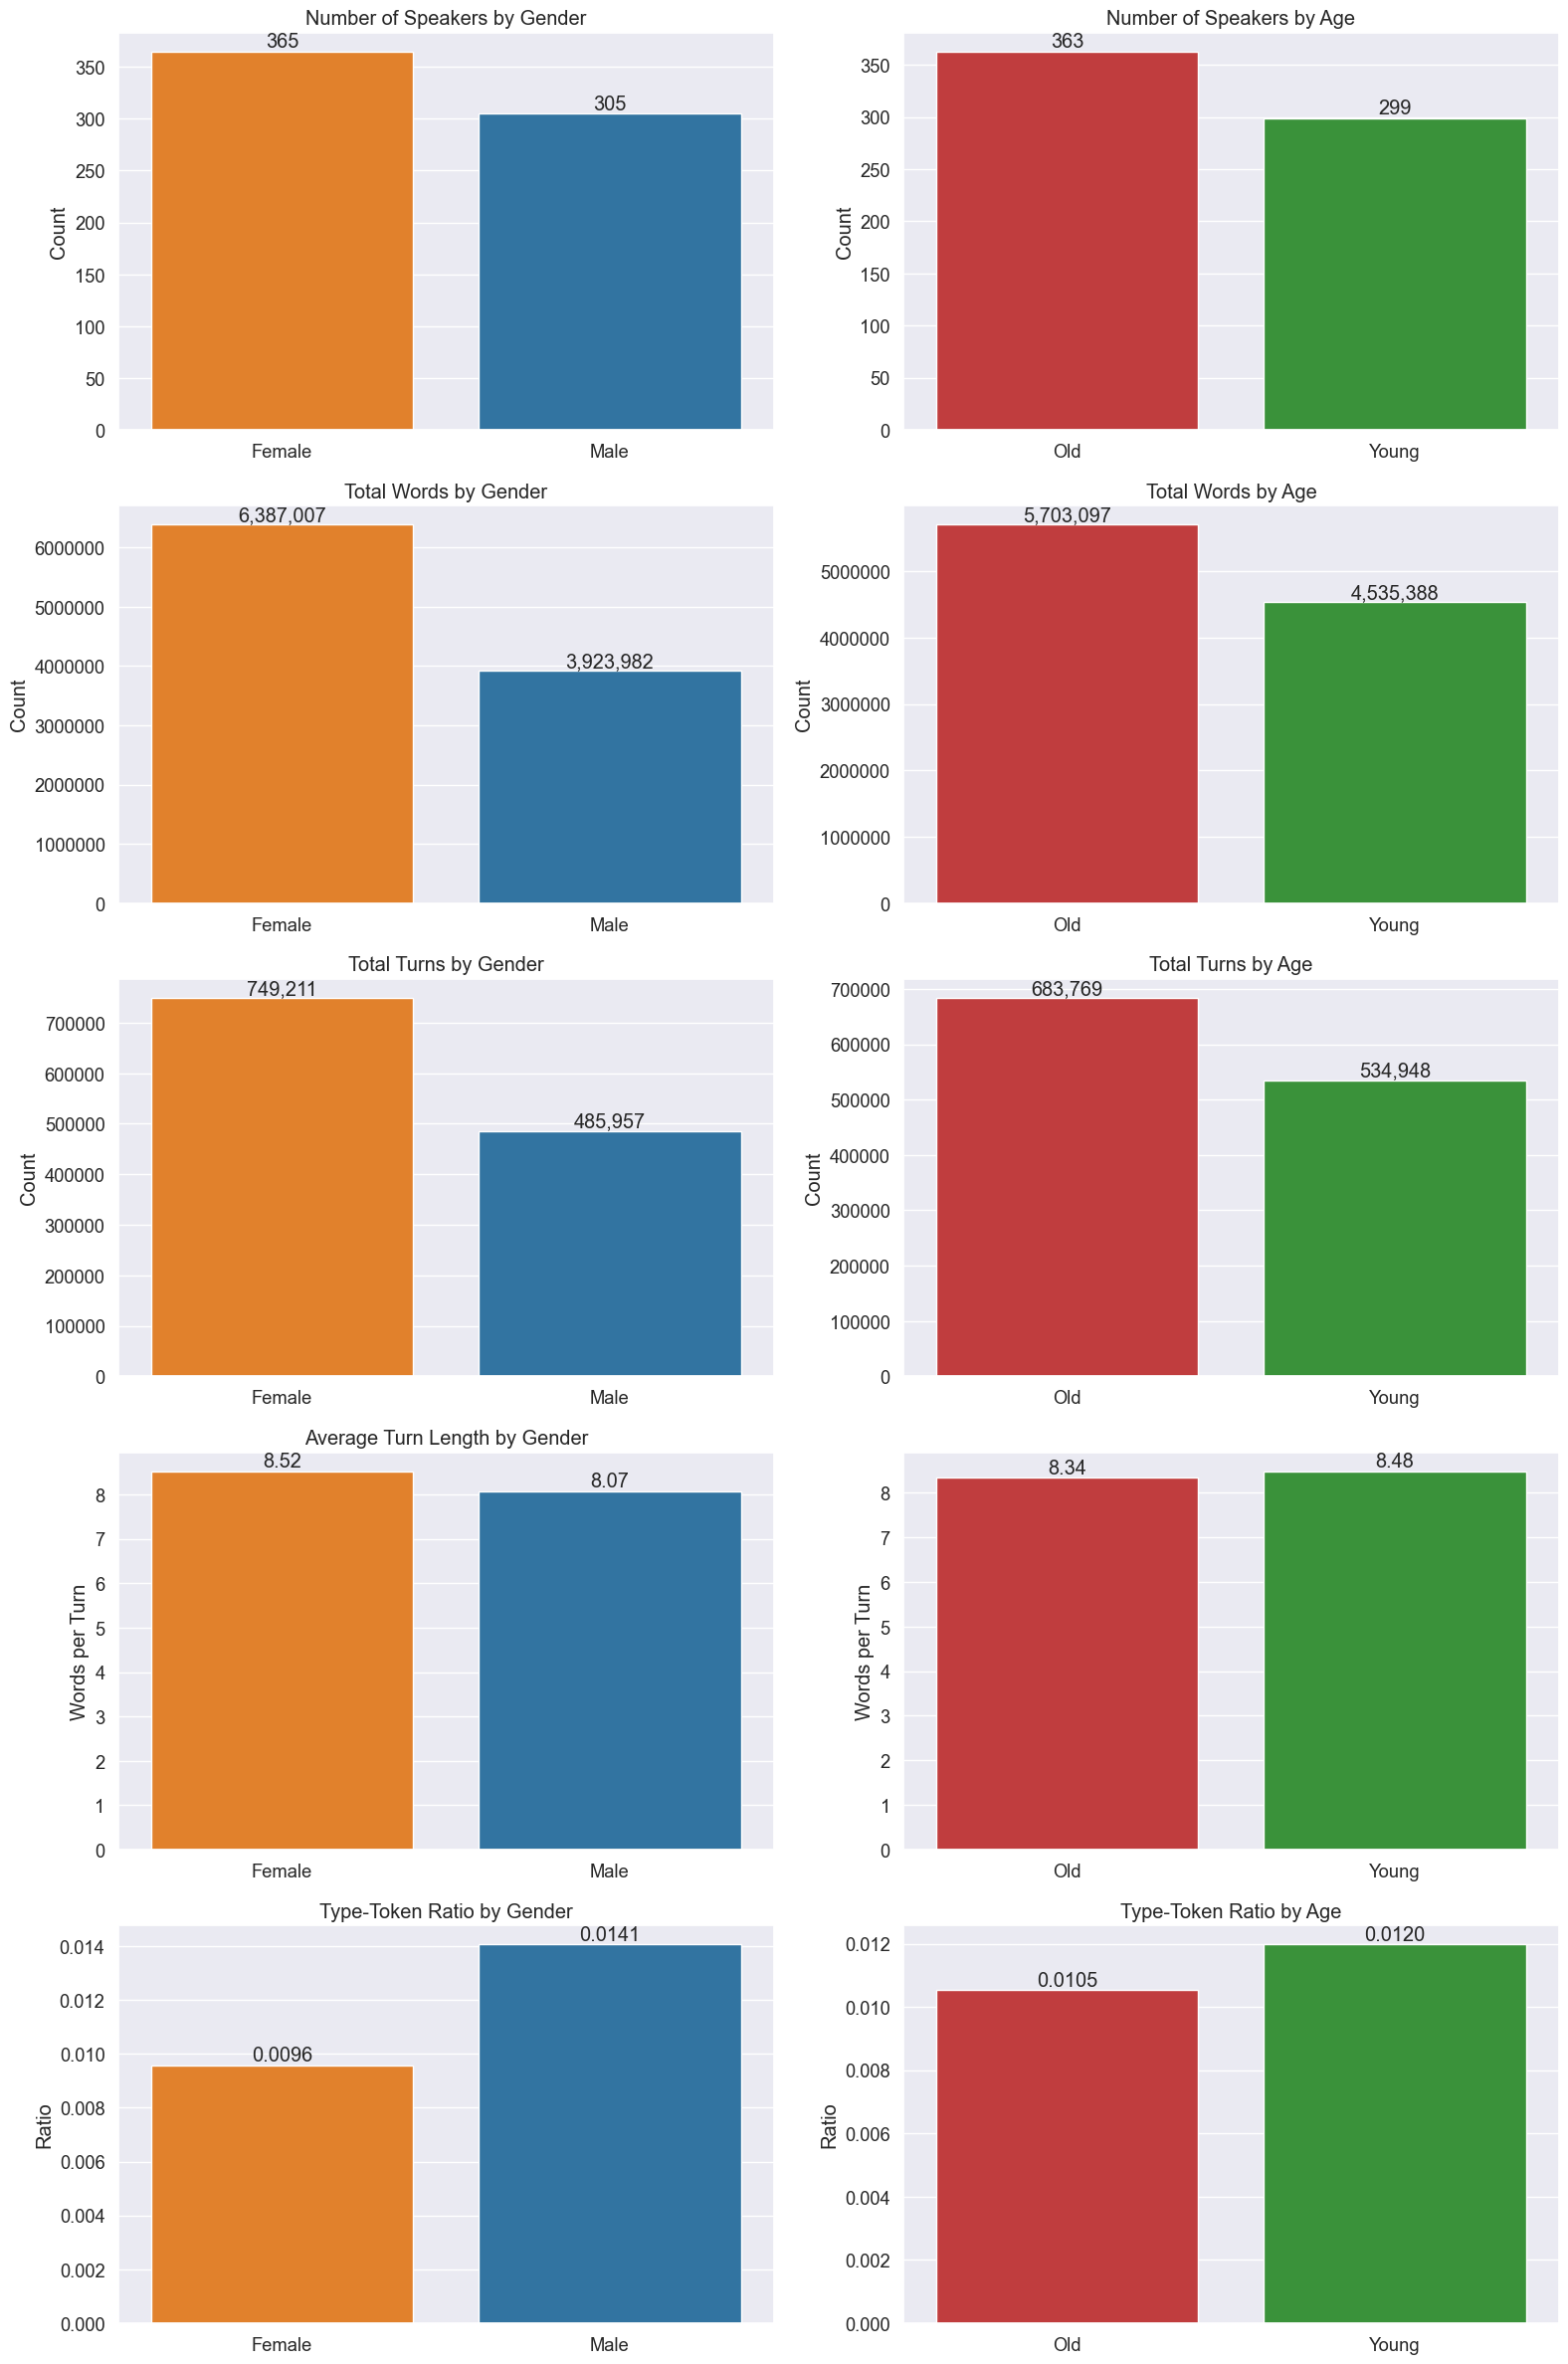

In [8]:
# Create visualizations of the statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Define colors
gender_colors = {'Female': '#ff7f0e', 'Male': '#1f77b4'}
age_colors = {'Young': '#2ca02c', 'Old': '#d62728'}

# Create a figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(16, 24))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# 1. Speakers by Gender
sns.barplot(x=['Female', 'Male'], y=[speaker_counts['Gender']['Female'], speaker_counts['Gender']['Male']], 
            palette=gender_colors, ax=axes[0])
axes[0].set_title('Number of Speakers by Gender')
axes[0].set_ylabel('Count')
for i, count in enumerate([speaker_counts['Gender']['Female'], speaker_counts['Gender']['Male']]):
    axes[0].annotate(f'{count}', xy=(i, count), ha='center', va='bottom')

# 2. Speakers by Age
sns.barplot(x=['Old', 'Young'], y=[speaker_counts['Age']['Old'], speaker_counts['Age']['Young']], 
            palette=age_colors, ax=axes[1])
axes[1].set_title('Number of Speakers by Age')
axes[1].set_ylabel('Count')
for i, count in enumerate([speaker_counts['Age']['Old'], speaker_counts['Age']['Young']]):
    axes[1].annotate(f'{count}', xy=(i, count), ha='center', va='bottom')

# 3. Words by Gender
sns.barplot(x=['Female', 'Male'], y=[words_by_category['Gender']['Female'], words_by_category['Gender']['Male']], 
            palette=gender_colors, ax=axes[2])
axes[2].set_title('Total Words by Gender')
axes[2].set_ylabel('Count')
axes[2].ticklabel_format(style='plain', axis='y')
for i, count in enumerate([words_by_category['Gender']['Female'], words_by_category['Gender']['Male']]):
    axes[2].annotate(f'{count:,}', xy=(i, count), ha='center', va='bottom')

# 4. Words by Age
sns.barplot(x=['Old', 'Young'], y=[words_by_category['Age']['Old'], words_by_category['Age']['Young']], 
            palette=age_colors, ax=axes[3])
axes[3].set_title('Total Words by Age')
axes[3].set_ylabel('Count')
axes[3].ticklabel_format(style='plain', axis='y')
for i, count in enumerate([words_by_category['Age']['Old'], words_by_category['Age']['Young']]):
    axes[3].annotate(f'{count:,}', xy=(i, count), ha='center', va='bottom')

# 5. Turns by Gender
sns.barplot(x=['Female', 'Male'], y=[turns_by_category['Gender']['Female'], turns_by_category['Gender']['Male']], 
            palette=gender_colors, ax=axes[4])
axes[4].set_title('Total Turns by Gender')
axes[4].set_ylabel('Count')
axes[4].ticklabel_format(style='plain', axis='y')
for i, count in enumerate([turns_by_category['Gender']['Female'], turns_by_category['Gender']['Male']]):
    axes[4].annotate(f'{count:,}', xy=(i, count), ha='center', va='bottom')

# 6. Turns by Age
sns.barplot(x=['Old', 'Young'], y=[turns_by_category['Age']['Old'], turns_by_category['Age']['Young']], 
            palette=age_colors, ax=axes[5])
axes[5].set_title('Total Turns by Age')
axes[5].set_ylabel('Count')
axes[5].ticklabel_format(style='plain', axis='y')
for i, count in enumerate([turns_by_category['Age']['Old'], turns_by_category['Age']['Young']]):
    axes[5].annotate(f'{count:,}', xy=(i, count), ha='center', va='bottom')

# 7. Average Turn Length by Gender
sns.barplot(x=['Female', 'Male'], y=[avg_turn_length['Gender']['Female'], avg_turn_length['Gender']['Male']], 
            palette=gender_colors, ax=axes[6])
axes[6].set_title('Average Turn Length by Gender')
axes[6].set_ylabel('Words per Turn')
for i, value in enumerate([avg_turn_length['Gender']['Female'], avg_turn_length['Gender']['Male']]):
    axes[6].annotate(f'{value:.2f}', xy=(i, value), ha='center', va='bottom')

# 8. Average Turn Length by Age
sns.barplot(x=['Old', 'Young'], y=[avg_turn_length['Age']['Old'], avg_turn_length['Age']['Young']], 
            palette=age_colors, ax=axes[7])
axes[8].set_title('Average Turn Length by Age')
axes[7].set_ylabel('Words per Turn')
for i, value in enumerate([avg_turn_length['Age']['Old'], avg_turn_length['Age']['Young']]):
    axes[7].annotate(f'{value:.2f}', xy=(i, value), ha='center', va='bottom')

# 9. Type-Token Ratio by Gender
sns.barplot(x=['Female', 'Male'], y=[type_token_ratio['Gender']['Female'], type_token_ratio['Gender']['Male']], 
            palette=gender_colors, ax=axes[8])
axes[8].set_title('Type-Token Ratio by Gender')
axes[8].set_ylabel('Ratio')
for i, value in enumerate([type_token_ratio['Gender']['Female'], type_token_ratio['Gender']['Male']]):
    axes[8].annotate(f'{value:.4f}', xy=(i, value), ha='center', va='bottom')

# 10. Type-Token Ratio by Age
sns.barplot(x=['Old', 'Young'], y=[type_token_ratio['Age']['Old'], type_token_ratio['Age']['Young']], 
            palette=age_colors, ax=axes[9])
axes[9].set_title('Type-Token Ratio by Age')
axes[9].set_ylabel('Ratio')
for i, value in enumerate([type_token_ratio['Age']['Old'], type_token_ratio['Age']['Young']]):
    axes[9].annotate(f'{value:.4f}', xy=(i, value), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.savefig('feature_category_counts_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Analysis

We've calculated various linguistic features across gender and age categories, including:

1. **Speaker counts**: The distribution of speakers by gender and age shows [analysis insight]
2. **Word counts**: Total words produced by each category reveals [analysis insight]
3. **Turn counts**: The number of conversational turns shows [analysis insight]
4. **Average turn length**: [Analysis insight about turn length differences]
5. **Type-token ratio**: This measure of lexical diversity indicates [analysis insight]

These statistics provide a foundation for understanding language variation across demographic categories in the BNC2014 corpus.